In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import cv2
import numpy as np

# ===============================
# PATHS
# ===============================
DATASET_ROOT = "/kaggle/input/pcb-defect-dataset/PCB_DATASET"
TEMPLATE_DIR = f"{DATASET_ROOT}/PCB_USED"
IMAGE_DIR = f"{DATASET_ROOT}/images"
OUTPUT_ROOT = "/kaggle/working/outputs"

# ===============================
# DEFECT CONFIG (FOR DETECTION ONLY)
# ===============================
DEFECTS = {
    "Missing_hole": (40, 800),
    "Mouse_bite": (120, 1500),
    "Open_circuit": (300, 5000),
    "Short": (300, 5000),
    "Spur": (80, 1200),
    "Spurious_copper": (300, 6000),
}

ROI_SIZE = 64

# ===============================
# CREATE OUTPUT FOLDERS
# ===============================
for d in DEFECTS:
    for sub in ["annotated", "masks", "rois"]:
        os.makedirs(f"{OUTPUT_ROOT}/{d}/{sub}", exist_ok=True)

# ===============================
# ECC ALIGNMENT
# ===============================
def align_images(t_gray, d_gray):
    warp = np.eye(2, 3, dtype=np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 80, 1e-6)
    try:
        cv2.findTransformECC(t_gray, d_gray, warp,
                             cv2.MOTION_EUCLIDEAN, criteria)
        return cv2.warpAffine(
            d_gray, warp,
            (t_gray.shape[1], t_gray.shape[0]),
            flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP
        )
    except:
        return d_gray

# ===============================
# MAIN PIPELINE
# ===============================
for defect, (MIN_AREA, MAX_AREA) in DEFECTS.items():
    print(f"\nProcessing {defect}")
    defect_path = f"{IMAGE_DIR}/{defect}"

    for img_name in os.listdir(defect_path):
        if not img_name.lower().endswith(".jpg"):
            continue

        pcb_id = img_name.split("_")[0]
        template_path = f"{TEMPLATE_DIR}/{pcb_id}.JPG"
        if not os.path.exists(template_path):
            continue

        template = cv2.imread(template_path)
        defect_img = cv2.imread(f"{defect_path}/{img_name}")
        if template is None or defect_img is None:
            continue

        # ---- PREPROCESS ----
        t_gray = cv2.GaussianBlur(
            cv2.cvtColor(template, cv2.COLOR_BGR2GRAY), (5,5), 0)
        d_gray = cv2.GaussianBlur(
            cv2.cvtColor(defect_img, cv2.COLOR_BGR2GRAY), (5,5), 0)

        d_aligned = align_images(t_gray, d_gray)
        diff = cv2.absdiff(t_gray, d_aligned)

        _, mask = cv2.threshold(
            diff, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        kernel = np.ones((5,5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        cv2.imwrite(f"{OUTPUT_ROOT}/{defect}/masks/{img_name}", mask)

        # ---- CONTOURS ----
        contours, _ = cv2.findContours(
            mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        annotated = defect_img.copy()
        H, W = defect_img.shape[:2]
        roi_id = 0

        for c in contours:
            area = cv2.contourArea(c)
            if area < MIN_AREA or area > MAX_AREA:
                continue

            x, y, w, h = cv2.boundingRect(c)

            # Draw bounding box (DO NOT FILTER)
            cv2.rectangle(
                annotated, (x,y), (x+w,y+h), (0,0,255), 2)

            # ---- FIXED 64×64 CONTEXT ROI ----
            x1 = x - 16
            y1 = y - 16
            x2 = x1 + ROI_SIZE
            y2 = y1 + ROI_SIZE

            if x1 < 0: x2 -= x1; x1 = 0
            if y1 < 0: y2 -= y1; y1 = 0
            if x2 > W: x1 -= (x2 - W); x2 = W
            if y2 > H: y1 -= (y2 - H); y2 = H

            roi = defect_img[y1:y2, x1:x2]
            if roi.shape[:2] != (ROI_SIZE, ROI_SIZE):
                continue

            roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

            roi_name = img_name.replace(".jpg", f"_roi_{roi_id}.jpg")
            cv2.imwrite(f"{OUTPUT_ROOT}/{defect}/rois/{roi_name}", roi_gray)
            roi_id += 1

        cv2.imwrite(
            f"{OUTPUT_ROOT}/{defect}/annotated/{img_name}", annotated)

print("\n✅ Detection & ROI generation completed")



Processing Missing_hole

Processing Mouse_bite

Processing Open_circuit

Processing Short

Processing Spur

Processing Spurious_copper

✅ Detection & ROI generation completed


In [2]:
TARGET_COUNTS = {
    "Missing_hole": 315,
    "Mouse_bite": 249,
    "Open_circuit": 223,
    "Short": 264,
    "Spur": 182,
    "Spurious_copper": 181,
}


In [3]:
import os
import cv2
import numpy as np

print("\n🔪 Pruning ROIs to exact target counts...")

for defect, target in TARGET_COUNTS.items():
    roi_dir = f"{OUTPUT_ROOT}/{defect}/rois"
    if not os.path.exists(roi_dir):
        print(f"⚠ Missing folder: {roi_dir}")
        continue

    roi_files = sorted(os.listdir(roi_dir))
    if len(roi_files) <= target:
        print(f"{defect}: already within limit ({len(roi_files)})")
        continue

    scored = []
    for f in roi_files:
        img = cv2.imread(os.path.join(roi_dir, f), 0)
        if img is None:
            continue

        # Score = edge strength (defect richness)
        edges = cv2.Canny(img, 50, 150)
        score = np.sum(edges)
        scored.append((score, f))

    scored.sort(reverse=True)
    keep = set([f for _, f in scored[:target]])

    for f in roi_files:
        if f not in keep:
            os.remove(os.path.join(roi_dir, f))

    print(f"{defect}: {target} ROIs retained")

print("\n🎯 ROI PRUNING COMPLETED SUCCESSFULLY")



🔪 Pruning ROIs to exact target counts...
Missing_hole: 315 ROIs retained
Mouse_bite: 249 ROIs retained
Open_circuit: 223 ROIs retained
Short: 264 ROIs retained
Spur: 182 ROIs retained
Spurious_copper: 181 ROIs retained

🎯 ROI PRUNING COMPLETED SUCCESSFULLY



🔍 Verifying Missing_hole


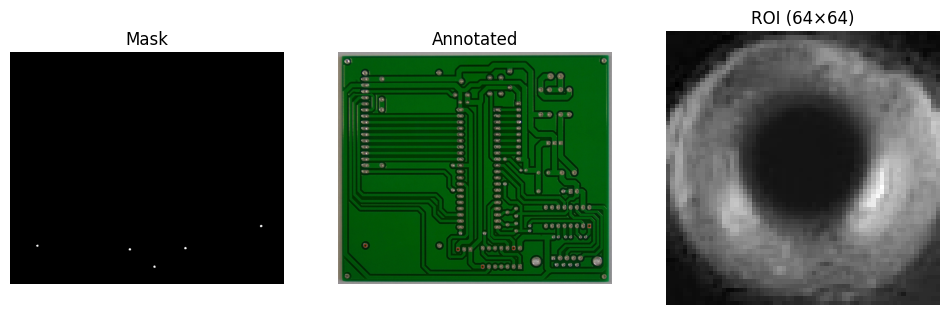


🔍 Verifying Mouse_bite


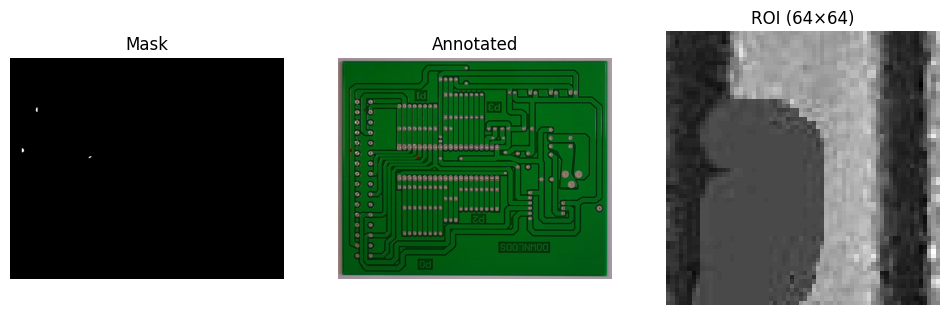


🔍 Verifying Open_circuit


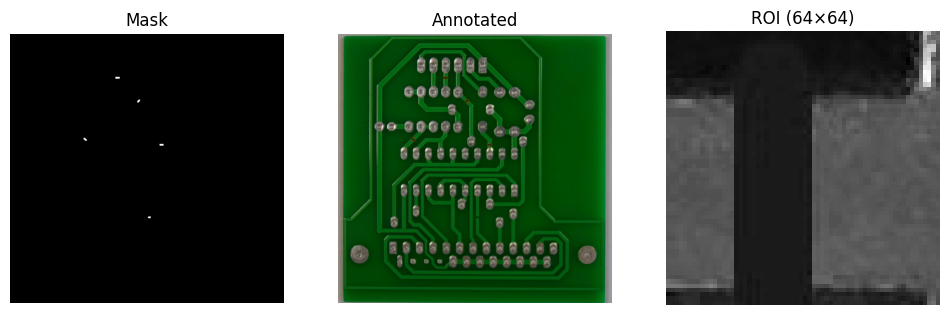


🔍 Verifying Short


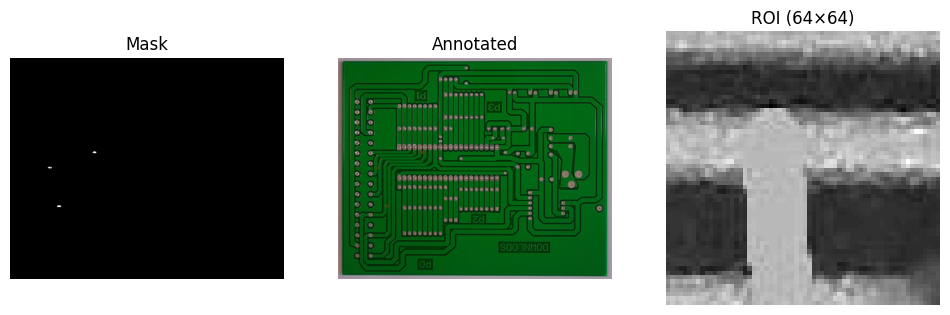


🔍 Verifying Spur


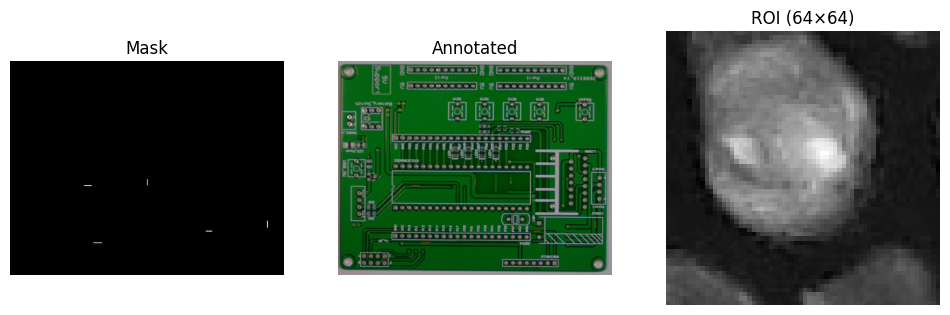


🔍 Verifying Spurious_copper


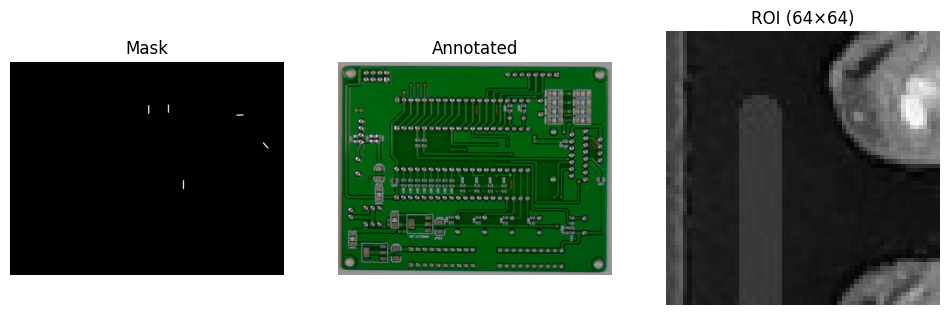

In [4]:
import cv2
import matplotlib.pyplot as plt
import os

DEFECTS = [
    "Missing_hole", "Mouse_bite", "Open_circuit",
    "Short", "Spur", "Spurious_copper"
]

for defect in DEFECTS:
    print(f"\n🔍 Verifying {defect}")

    ann_dir = f"/kaggle/working/outputs/{defect}/annotated"
    mask_dir = f"/kaggle/working/outputs/{defect}/masks"
    roi_dir  = f"/kaggle/working/outputs/{defect}/rois"

    if not os.listdir(ann_dir):
        continue

    img = os.listdir(ann_dir)[0]

    ann  = cv2.imread(f"{ann_dir}/{img}")
    mask = cv2.imread(f"{mask_dir}/{img}", 0)
    roi  = cv2.imread(f"{roi_dir}/{os.listdir(roi_dir)[0]}", 0)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.title("Mask"); plt.imshow(mask, cmap="gray"); plt.axis("off")
    plt.subplot(1,3,2); plt.title("Annotated"); plt.imshow(cv2.cvtColor(ann, cv2.COLOR_BGR2RGB)); plt.axis("off")
    plt.subplot(1,3,3); plt.title("ROI (64×64)"); plt.imshow(roi, cmap="gray"); plt.axis("off")
    plt.show()
